### To load the saved model and run it on the test data, run the cells marked with #+  

In [1]:
#+
import collections
from typing import List
import numpy as np     
from nltk.corpus import stopwords
from keras import models
from keras import layers
import numpy as np
from keras.models import load_model
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import setUpFunctions
import evaluation
nltk.download('stopwords')                         
import matplotlib.pyplot as plt     

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading in the data

In [2]:
#+ unselect wanted language option
language ='es'
# language ='es'

if(language == 'en'): 
    lang= 'English'
else:
    lang='Spanish'

In [3]:
#+
train = setUpFunctions.getTrainTweets(language)
test = setUpFunctions.getTestTweets(language)
val = setUpFunctions.getTrialTweets(language)

In [4]:
#+
traintweets = train['tweet']
trainlabels = train['emoji']
valtweets = val['tweet']
vallabels = val['emoji']  
testtweets = test['tweet']
testlabels = test['emoji']

In [5]:
#+
train_tweets = [tweet.strip().split() for tweet in traintweets] 
train_labels = [int(label.strip()) for label in trainlabels]
test_tweets = [tweet.strip().split() for tweet in testtweets]
test_labels = [int(label.strip()) for label in testlabels]
val_tweets = [tweet.strip().split() for tweet in valtweets]
val_labels = [int(label.strip()) for label in vallabels]

## Function to clean the data

In [6]:
#+
def cleanTweets(tweets: List[List[str]]) -> List[List[str]]:
    cleanedTweets: List[List[str]] = []
    for tweet in tweets:
        cleanTweet: List[str] = ['START']
        for token in tweet:
            token = token.lower()
            cleanTweet.append(token)
        cleanedTweets.append(cleanTweet)
    return cleanedTweets

## Function to extract vocabulary from the tweets

In [7]:
#+
def extractVocab(tweets: List[List[str]], min_freq: int):
    tokenFreq = collections.defaultdict(lambda: 0)
    for tweet in tweets:
        for token in tweet:
            tokenFreq[token] += 1
    vocab = sorted(tokenFreq.keys(), key=tokenFreq.get, reverse=True)

    while tokenFreq[vocab[-1]] < min_freq:
        vocab.pop()

    vocab.remove('START')

    return ['PAD', 'START', 'UNKNOWN'] + vocab

## Function to index the tweets

In [8]:
#+
def indexTweets(tweets: List[List[str]]) -> List[List[int]]:
    return [ [ token2index[token] for token in tweet ] for tweet in tweets ]

## Function to pad the tweets

In [9]:
#+
def padTweets(tweets: List[List[int]]) -> np.ndarray:
    maxTweetLength = max(len(tweet) for tweet in tweets)
    paddedTweets = np.zeros([len(tweets), maxTweetLength], np.int32)
    for (i, tweet) in enumerate(tweets):
        paddedTweets[i, :len(tweet)] = tweet

    return paddedTweets

## Applying the above functions to our data

In [10]:
#+
cleanTrainTweets: List[List[str]] = cleanTweets(train_tweets)
cleanValTweets: List[List[str]] = cleanTweets(val_tweets)

In [11]:
#+
vocab = extractVocab(cleanTrainTweets, 3)

In [12]:
#+
token2index = collections.defaultdict(lambda: 2)
for (index, token) in enumerate(vocab):
    token2index[token] = index
    
train_tweets_index: List[List[int]] = indexTweets(cleanTrainTweets)
val_tweets_index: List[List[int]] = indexTweets(cleanValTweets)

In [13]:
#+
train_tweets_padded: np.ndarray = padTweets(train_tweets_index)
val_tweets_padded: np.ndarray = padTweets(val_tweets_index)       

# Simple RNN

In [ ]:
model_SRNN = models.Sequential()
model_SRNN.add(layers.Embedding(len(vocab), 64, input_length=None, mask_zero=True))  
model_SRNN.add(layers.SimpleRNN(64, dropout=0.5))
model_SRNN.add(layers.Dense(20, activation='softmax'))

In [ ]:
model_SRNN.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy', 
                    metrics=['acc'])

In [ ]:
history = model_SRNN.fit(np.array(train_tweets_padded), np.array(train_labels),
                          epochs=5, batch_size=32, 
                          validation_data=(np.array(val_tweets_padded), np.array(val_labels)))

## Saving the model


In [ ]:
model_SRNN.save('models/'+lang+'SRNNModel.h5')

# LSTM

In [ ]:
model_LSTM = models.Sequential()
model_LSTM.add(layers.Embedding(len(vocab), 64, input_length=None, mask_zero=True))  
model_LSTM.add(layers.LSTM(64, dropout=0.5))
model_LSTM.add(layers.Dense(20, activation='softmax'))

In [ ]:
model_LSTM.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['acc'])

In [ ]:
history = model_LSTM.fit(np.array(train_tweets_padded), np.array(train_labels),
                          epochs=5, batch_size=32, 
                          validation_data=(np.array(val_tweets_padded), np.array(val_labels)))

## Saving the model

In [ ]:
model_LSTM.save('models/'+lang+'LSTMModel.h5')

# GRU

In [ ]:
model_GRU = models.Sequential()
model_GRU.add(layers.Embedding(len(vocab), 64, input_length=None, mask_zero=True))  
model_GRU.add(layers.GRU(64, dropout=0.5))
model_GRU.add(layers.Dense(20, activation='softmax'))

In [ ]:
model_GRU.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['acc'])

In [ ]:
history = model_GRU.fit(np.array(train_tweets_padded), np.array(train_labels),
                          epochs=5, batch_size=32, 
                          validation_data=(np.array(val_tweets_padded), np.array(val_labels)))

## Saving the model


In [ ]:
model_GRU.save('models/'+lang+'GRUModel.h5')

## Bidirectional RNN

In [ ]:
model_BI_SRNN = models.Sequential()
model_BI_SRNN.add(layers.Embedding(len(vocab), 64, input_length=None, mask_zero=True))  
model_BI_SRNN.add(layers.Bidirectional(layers.SimpleRNN(64, dropout=0.5)))
model_BI_SRNN.add(layers.Dense(20, activation='softmax'))

In [ ]:
model_BI_SRNN.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['acc'])

In [ ]:
history = model_BI_SRNN.fit(np.array(train_tweets_padded), np.array(train_labels),
                          epochs=5, batch_size=32, 
                          validation_data=(np.array(val_tweets_padded), np.array(val_labels)))

## Saving the model

In [ ]:
model_BI_SRNN.save('models/'+lang+'BidirectionalSRNNModel.h5')

## LSTM RNN

In [ ]:
# model_LSTM_RNN = models.Sequential()
# model_LSTM_RNN.add(layers.Embedding(len(vocab), 64, input_length=None, mask_zero=True))  
# model_LSTM_RNN.add(layers.LSTM(64, dropout=0.5, return_sequences=True))
# model_LSTM_RNN.add(layers.SimpleRNN(32, dropout=0.5))
# model_LSTM_RNN.add(layers.Dense(19, activation='softmax'))

In [ ]:
# model_LSTM_RNN.compile(optimizer='adam',
#                     loss='sparse_categorical_crossentropy',
#                     metrics=['acc'])

In [ ]:
# history = model_LSTM_RNN.fit(np.array(train_tweets_padded), np.array(train_labels),
#                           epochs=5, batch_size=32, 
#                           validation_data=(np.array(val_tweets_padded), np.array(val_labels)))

## Evaluation

In [14]:
#+
#The path has to be changed according to the model that you would like to test 
model_RNN = load_model('models/'+lang+'LSTMModel.h5')

In [15]:
# train_losses = history.history['loss']
# val_losses = history.history['val_loss']
# epochs = range(1, len(history.history['loss']) + 1)
# plt.plot(epochs, train_losses, 'b-', label='Train loss')
# plt.plot(epochs, val_losses, 'r-', label='Val loss')
# plt.title('Train and val loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.ylim(0, 6)
# plt.grid()
# plt.legend()
# plt.show()

In [16]:
#+
def confusion_matrix(gold_labels, predicted):
    classes = np.unique(gold_labels)

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(gold_labels, predicted)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

In [17]:
#+
test_tweets_clean: List[List[str]] = cleanTweets(test_tweets)
test_tweets_index: List[List[int]] = indexTweets(test_tweets_clean)
test_tweets_padded: np.ndarray = padTweets(test_tweets_index)

softmax_output: List[List[float]] = model_RNN.predict(test_tweets_padded)
predicted_values: List[int] = []
for scores in softmax_output:
    highest_score_label: int = np.argmax(scores)
    predicted_values.append(highest_score_label)

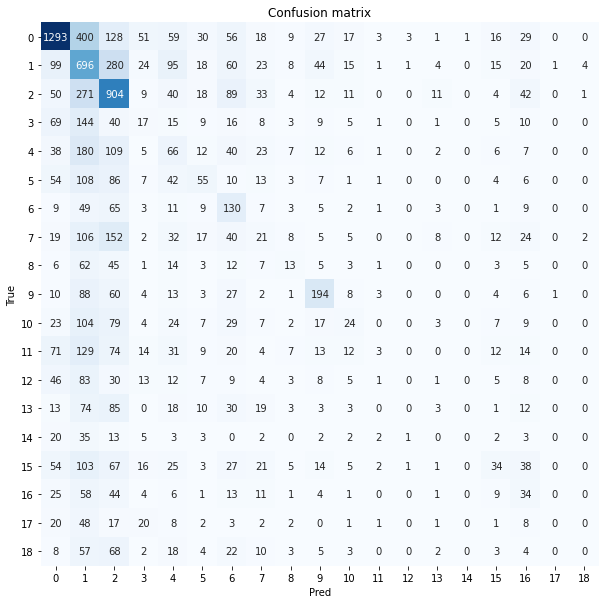

In [18]:
#+
confusion_matrix(test_labels, predicted_values)

In [19]:
#+
evaluation.main(test_labels, predicted_values)

Macro F-Score (official): 16.372
-----
Micro F-Score: 34.87
Precision: 34.87
Recall: 34.87
